# Session-Based Recommendation

- Session-Based Recommendation은 말 그대로 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천시스템

- 저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장

- 유저의 행동 데이터들은 유저측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용

- 이번 자료에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용


- 쿠키는 내 브라우저에 저장되는데 이걸 임의로 수정할 수 있다. 그래서 서버의 세션에서 관리하고 HTTP키를통해 정보 주고받음
  - 응답 헤더에 set-cookie: user=~ 설정
  - clinet는 GET으로 보내면됨

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

- 위 data와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 Sequential Recommendation -> Context-Aware

# Preprocessing

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/home/aiffel-dj45/aiffel/yoochoose-data/ml-1m/ratings.dat')

- pandas dataframe으로 테이블 생성

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 

- 세션 수, item수

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

-  같은 유저가 여러 개의 세션을 만들수도 있음

## Session Length

- SessionId는 clinet에서 login POST request올때 서버 세션에 저장되는 정보

In [6]:
#session_length = data.groupby('UserId')['ItemId'].count()
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [8]:
session_length.min(), session_length.max()

(20, 2314)

In [9]:
session_length.quantile(0.999)

1343.181000000005

In [10]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


In [11]:
Anomaly_4169 = data[data['UserId']==long_session].groupby('Time')['ItemId'].count()

Anomaly_4169.sort_values(ascending=False)

Time
968798481     10
971581120     10
971580156     10
971580055     10
966700317     10
              ..
978664059      1
979525231      1
979525309      1
979525488      1
1024176337     1
Name: ItemId, Length: 684, dtype: int64

#### 4169뿐만아니라 아이디 돌려막기 하는놈들 많을텐데 이번 한번만 봐줍니다

- 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화

In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

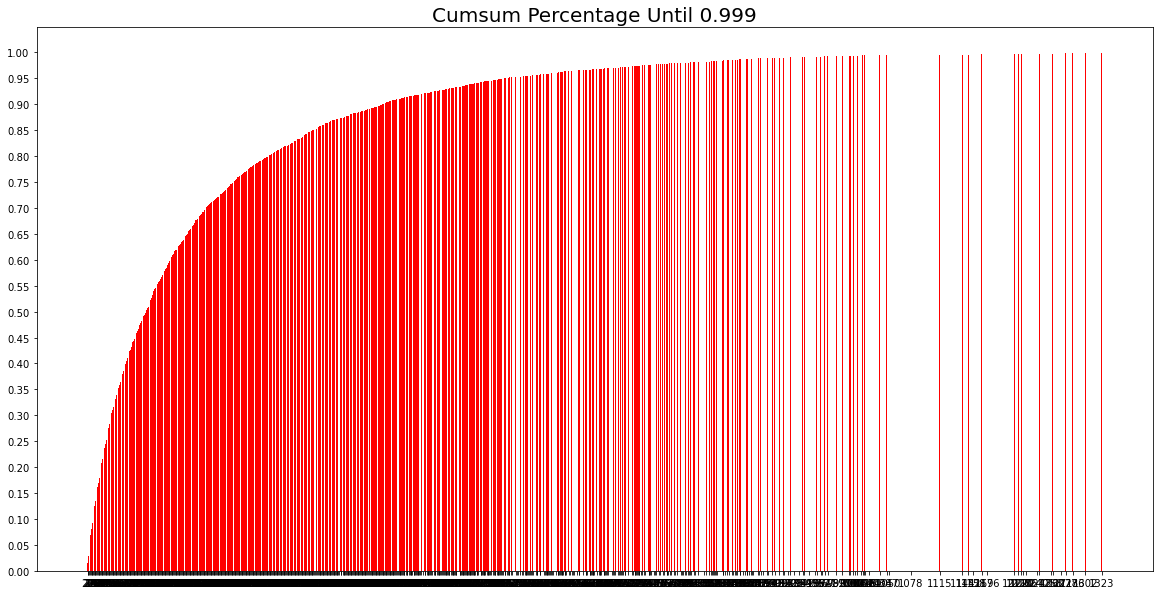

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용
  - but 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 User*Item은 saparse하다

## Data Cleansing

- 목적은 __유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것__ 이므로 길이가 1인 세션은 제거

- 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거

- df SessionId로 groupby시켜서 .size()함수를 통해 시리즈 뽑아내고
- 인덱스가된 SessionId를통해 인덱싱하고 그걸 isin에 사용

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        #data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


'''def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data'''


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 최소클릭 1인사람 없고 5번이하클릭은 찌끔있는데 그거 버림

## Train/ Valid/ Test split

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999611 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   UserId  999611 non-null  int32
 1   ItemId  999611 non-null  int32
 2   Rating  999611 non-null  int32
 3   Time    999611 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [17]:
import datetime as dt

format_time = []

for t in data['Time']:
    format_time.append(dt.datetime.fromtimestamp(t))

data['Format_Time'] = format_time
data

,UserId,ItemId,Rating,Time,Format_Time
31,1,3186,4,978300019,2001-01-01 07:00:19
22,1,1270,5,978300055,2001-01-01 07:00:55
27,1,1721,4,978300055,2001-01-01 07:00:55
37,1,1022,5,978300055,2001-01-01 07:00:55
24,1,2340,3,978300103,2001-01-01 07:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 23:40:29
999988,6040,1921,4,997454464,2001-08-10 23:41:04
1000172,6040,1784,3,997454464,2001-08-10 23:41:04
1000167,6040,161,3,997454486,2001-08-10 23:41:26


In [18]:
data['Format_Time'].min()

Timestamp('2000-04-26 08:05:32')

In [19]:
data['Format_Time'].max()

Timestamp('2003-03-01 02:49:50')

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Format_Time'].max()
    session_last_time = data.groupby('UserId')['Format_Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [22]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Format_Time"].min()}\n'
          f'\t Last Time : {data["Format_Time"].max()}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 860249
	 Sessions: 5701
	 Items: 3416
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-09-01 09:14:13

* valid Set Stats Info
	 Events: 41662
	 Sessions: 106
	 Items: 3030
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-30 22:47:32

* test Set Stats Info
	 Events: 97700
	 Sessions: 233
	 Items: 3279
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



- timeseries예측이 아니기에 시간대로 짜르지 않고 걍 ㄱㄱ

In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다. (get 두번째인자)
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# GRU4REC

- session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표

- Session-Parallel Mini-Batches 
  - Session길이는 대부분 매우 짧지만 비정상적으로 긴것도있기에

# Data Pipeline

- Session-Parallel Mini-Batch 구현

## SessionDataset

- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)  # nunique() : num of unique
        offsets[1:] = self.df.groupby('UserId').size().cumsum()  # cumsum() : 누적 합 (cumulative sums) 
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.

session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Format_Time,item_idx
31,1,3186,4,978300019,2001-01-01 07:00:19,0
22,1,1270,5,978300055,2001-01-01 07:00:55,1
27,1,1721,4,978300055,2001-01-01 07:00:55,2
37,1,1022,5,978300055,2001-01-01 07:00:55,3
24,1,2340,3,978300103,2001-01-01 07:01:43,4
36,1,1836,5,978300172,2001-01-01 07:02:52,5
3,1,3408,4,978300275,2001-01-01 07:04:35,6
7,1,2804,5,978300719,2001-01-01 07:11:59,7
47,1,1207,4,978300719,2001-01-01 07:11:59,8
0,1,1193,5,978300760,2001-01-01 07:12:40,9


In [28]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 859785, 859908, 860249], dtype=int32)

In [29]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5698, 5699, 5700])

## SessionDataLoader

- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다

- __iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.

- mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [41]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df

,UserId,ItemId,Rating,Time,Format_Time,item_idx
31,1,3186,4,978300019,2001-01-01 07:00:19,0
22,1,1270,5,978300055,2001-01-01 07:00:55,1
27,1,1721,4,978300055,2001-01-01 07:00:55,2
37,1,1022,5,978300055,2001-01-01 07:00:55,3
24,1,2340,3,978300103,2001-01-01 07:01:43,4
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 23:40:29,1248
999988,6040,1921,4,997454464,2001-08-10 23:41:04,370
1000172,6040,1784,3,997454464,2001-08-10 23:41:04,89
1000167,6040,161,3,997454486,2001-08-10 23:41:26,464


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# Modeling

## Evaluation Metric

- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다

- 이번 자료에서는 recall의 개념을 확장한 recall@k 지표, 순서에 민감한 지표인 MRR 사용
  - MRR은 정답 아이템이 나온 순번의 역수 값
  - 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- 모델에 사용할 hyper-parameter를 class형식으로 관리

In [42]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.2, lr=0.001, epochs=3, k=20)

In [43]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [44]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
train_model(model, args)

Train:   0%|          | 0/13352 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.85]

	 - Recall@20 epoch 1: 0.248750
	 - MRR@20    epoch 1: 0.064909



Train:   0%|          | 0/13352 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.36]

	 - Recall@20 epoch 2: 0.293170
	 - MRR@20    epoch 2: 0.083059



Evaluation:  54%|█████▍    | 350/649 [01:18<01:06,  4.47it/s]

	 - Recall@20 epoch 3: 0.312946
	 - MRR@20    epoch 3: 0.091213



# Inference

In [46]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  80%|████████  | 1218/1522 [04:39<01:09,  4.36it/s]

	 - Recall@20: 0.254503
	 - MRR@20: 0.071722



# Nice